In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [4]:
error_correction_training_fn='error_correction.tsv'

In [5]:
with open(error_correction_training_fn, 'r', encoding='utf-8') as f:
    training=f.read()
GP=training.split('\n')

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:
graphemes=list(sorted(set([x for x in training if x not in ['\n', '\t']])))

In [7]:
GP=[x.split('\t') for x in GP]

In [10]:
MAX_LENGTH=max([max(len(a), len(b)) for a,b in GP])+50

In [11]:
import random
import torch
from torchtext.data import Field, BucketIterator

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [12]:
from torchtext.data import Iterator

In [13]:
from torchtext.data import TabularDataset
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [33]:
MIN_FREQ=1

In [34]:
SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

In [35]:
TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [36]:
from seq_to_seq import *

In [20]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

In [21]:
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

In [22]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [23]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [24]:
model_fn='tut6-model.pt'

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,202,222 trainable parameters


In [26]:
import os
os.path.exists(model_fn)

False

In [27]:
import os

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [28]:
model.train();

In [49]:
512*11.6/9.3

638.6236559139784

In [50]:
batch_size=638
train_iterator = Iterator(train_data, batch_size=batch_size)

In [52]:
print(f'{len(train_iterator)} batches / epoch')

56 batches / epoch


In [55]:
epoch_loss = 9999999999999999
j=0

<IPython.core.display.Javascript object>


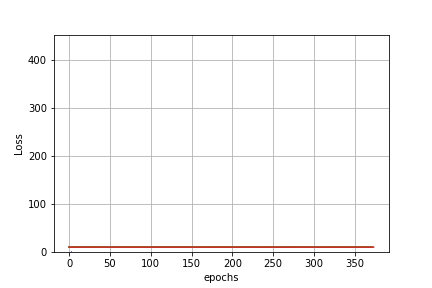

Text(0, 0.5, 'Loss')

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt

def progress_bar(ax, progress):
    ax.plot(progress)
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')

In [ ]:
losses = []
while epoch_loss > 0.1:
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    j += 1
    losses.append(epoch_loss)
    progress_bar(ax, losses)

In [57]:
!mkdir -p save/afterburner

In [64]:
model_fn='save/afterburner/afterburner_002.pt'

In [65]:
torch.save(model.state_dict(), model_fn)

### Translate BUILD a whole split at a time, using SubSplit splitting method, and correct that

In [103]:
@np.vectorize
def to_amharic(x):
    return TRG.vocab.itos[x]

In [169]:
def eos_trim(v):
    try:
        return ''.join(v[0:np.where(v=='<eos>')[0][0]])
    except:
        return ''.join(v)

In [128]:
def prediction_to_string(output):
    pred=output.cpu().detach().numpy()
    sample_length=pred.shape[0]//batch_size
    p2=[pred[i*sample_length:(i+1)*sample_length] for i in range(batch_size)]
    p3=[to_amharic(x.argmax(axis=1)) for x in p2]
    p4=[eos_trim(x) for x in p3]
    return p4

In [132]:
def gold_to_string(trg):
    pred=trg.cpu().detach().numpy()
    sample_length=pred.shape[0]//batch_size
    p2=[pred[i*sample_length:(i+1)*sample_length] for i in range(batch_size)]
    p3=[to_amharic(x) for x in p2]
    p4=[eos_trim(x) for x in p3]
    return p4

In [161]:
from tqdm.notebook import tqdm

In [139]:
import sys
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')
os.environ['IN_JUPYTER']='True'
from utils.metrics import calculate_cer, calculate_wer

In [166]:
model.eval();

In [167]:
batch_size=128
train_iterator = Iterator(train_data, batch_size=batch_size)

In [170]:
R=[]
for i, batch in enumerate(tqdm(train_iterator)):
    src = batch.src.to(device)
    trg = batch.trg.to(device)
    output, _ = model(src, trg[:,:-1])
    output_dim = output.shape[-1]
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:,1:].contiguous().view(-1)   
    prediction=prediction_to_string(output)
    gold=gold_to_string(trg)   
    for hyp,au in zip(prediction, gold):
        R.append((au,hyp,calculate_cer(hyp, au),calculate_wer(hyp, au)))

In [172]:
len(R), R[0]

(35584, ('አይዞህ', 'አይዞህ', 0, 0))

In [175]:
import pandas as pd
results=pd.DataFrame(R, columns=['Gold', 'Pred', 'CER', 'WER'])
results['GOLD_n_words']=results['Gold'].apply(lambda x: len(x.split(' ')))
results['GOLD_n_chars']=results['Gold'].apply(lambda x: len(x))
results['CER_pct']=results.CER/results['GOLD_n_chars']
results['WER_pct']=results.CER/results['GOLD_n_words']

In [182]:
results=results[results.Gold != '<pad>']

<IPython.core.display.Javascript object>


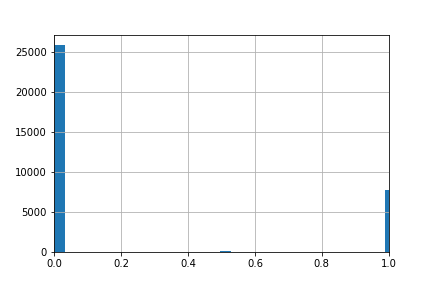

(0.0, 1.0)

In [185]:
%matplotlib notebook
results.WER_pct.hist(bins=1000)
plt.xlim(0,1)

In [186]:
results.WER_pct.mean()

0.3286607137274029

In [187]:
results.CER_pct.mean()

0.13814833688962844

### Translate BUILD a whole recording at a time, using SubSplit splitting method, and correct that